# 1000 epoha treniranja uz nasumičnu varijaciju PP filtra svakih 5 epoha treniranja

In [115]:
import sys
sys.path.append('helpers/')

from pprint import pprint
import scipy.io as scio
from torch.utils.data import Dataset, DataLoader
from eegdProcessors import getLabeledEpochs, DownSample, BPButter4, F_RemoveOutliers, Normalise
import random
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from torchvision import transforms
import torch.optim as optim
import torch.nn.functional as F

In [116]:
eeg_1s_raw = scio.loadmat('./data/subject_1_eeg_separated_epochs_1s.mat')

In [117]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(device)

cuda:0


In [118]:
len(getLabeledEpochs(eeg_1s_raw, 1/3, filterChain=[F_RemoveOutliers(200)]))

1192

In [119]:
# Definiranje klase pyTorch dataseta za eeg podatke

class eegDataset(Dataset):
    labels = ('Target', 'non Target')

    def __init__(self, eeg_raw, ratio, seed, transform=None, filterChain = []):
        self.epochs = getLabeledEpochs(eeg_raw, ratio, seed=seed, filterChain=filterChain)
        self.transform = transform

    def __len__(self):
        return len(self.epochs)

    def __getitem__(self, idx):
        label = self.epochs[idx][0]
        epoch = self.epochs[idx][1]

        # Ako je dan transformer podataka
        # poslati podatke kroz njega
        if self.transform:
            epoch = self.transform(epoch)

        return torch.from_numpy(np.expand_dims(epoch, axis=0)), label

In [120]:
# Definiranje dataloadera

downsapling = 1
# Prvo se podatci downsampleaju downsapling puta
# zatim se filtriraju PP Butt filtrom 4. reda od 0.1hz do 20hz
# zatim se podatci normaliziraju po (pdf: CNN for P300 Detec... sekcija 3.1 na stranici 436)
training_data = eegDataset(eeg_1s_raw, 1/3, 'abc', transform=transforms.Compose([
    DownSample(downsapling),
    BPButter4(0.1, 20, 512/downsapling),
    Normalise()
]), filterChain=[
    F_RemoveOutliers(200)
])


train_dataloader = DataLoader(training_data, batch_size=4, shuffle=True)


Feature batch shape: torch.Size([4, 1, 16, 512])
Labels batch shape: torch.Size([4])


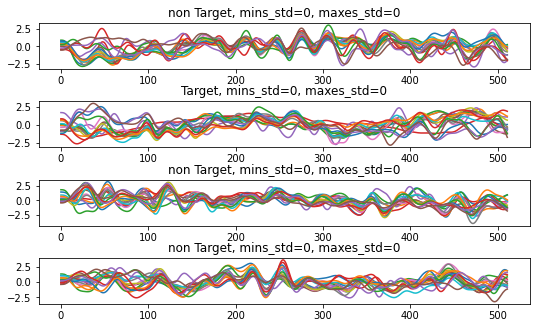

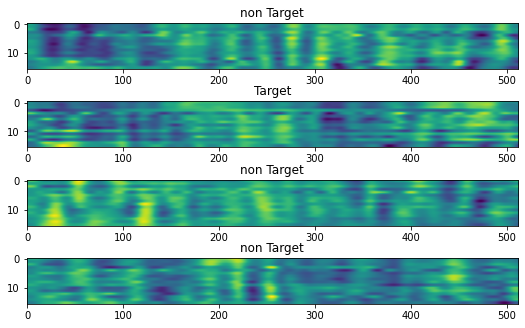

In [121]:
# Vizualizacija jednog batcha

train_ephs, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_ephs.size()}")
print(f"Labels batch shape: {train_labels.size()}")

fig2, ax2 = plt.subplots(len(train_ephs))
for key, itm in enumerate(train_ephs):
    item = itm[0]
    # Racunanje standardne devijacije maximuma i minimuma mjerenja elektroda
    mins = []
    maxes = []
    for line in item:
        ax2[key].plot(line)
        mins.append(line.min())
        maxes.append(line.max())
    mins = np.array(mins)
    maxes = np.array(maxes)
    label = training_data.labels[train_labels[key]] + ", mins_std=" + str(int(mins.std())) + ", maxes_std=" + str(int(maxes.std()))
    ax2[key].set_title(label)
    ax2[key].set_aspect('auto')

fig2.set_figwidth(2.2*len(train_ephs))
fig2.set_figheight(len(train_ephs))
fig2.subplots_adjust(top=1.1, hspace=0.7)



fig, ax = plt.subplots(len(train_ephs))
for key, itm in enumerate(train_ephs):
    item = itm[0]
    label = training_data.labels[train_labels[key]]
    ax[key].set_title(label)
    ax[key].imshow(item)
    ax[key].set_aspect('auto')

fig.set_figwidth(2.2*len(train_ephs))
fig.set_figheight(len(train_ephs))
fig.subplots_adjust(top=1.1, hspace=0.7)



In [122]:
class EEGNet(nn.Module):
    def __init__(self):
        super(EEGNet, self).__init__()

        self.F1 = 8
        self.F2 = 16
        self.D = 2
        
        # Conv2d(in,out,kernel,stride,padding,bias)
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, self.F1, (1, 8), padding=(0, 32), bias=False),
            nn.BatchNorm2d(self.F1)
        )
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(self.F1, self.D*self.F1, (4, 1), groups=self.F1, bias=False),
            nn.BatchNorm2d(self.D*self.F1),
            nn.ELU(),
            nn.AvgPool2d((1, 4)),
            nn.Dropout(0.5)
        )
        
        self.Conv3 = nn.Sequential(
            nn.Conv2d(self.D*self.F1, self.D*self.F1, (1, 16), padding=(0, 8), groups=self.D*self.F1, bias=False),
            nn.Conv2d(self.D*self.F1, self.F2, (1, 1), bias=False),
            nn.BatchNorm2d(self.F2),
            nn.ELU(),
            nn.AvgPool2d((1, 8)),
            nn.Dropout(0.5)
        )
        
        self.classifier = nn.Linear(16*13*17, 9*4, bias=True)
        self.classifier2 = nn.Linear(9*4, 2, bias=True)
        self.classifier3 = nn.Linear(2, 2, bias=True)
        
    def forward(self, x):
        
        x = self.conv1(x.float())
        # print(x.shape)
        x = self.conv2(x.float())
        # print(x.shape)
        x = self.Conv3(x.float())
        # print(x.shape)
        
        x = x.view(-1, 16*13*17)
        # print(x.shape)
        x = self.classifier(x.float())
        x = F.relu(x)
        x = self.classifier2(x.float())
        x = self.classifier3(x.float())
        # print(x.shape)
        return x

In [123]:
eegnet = EEGNet().to(device).float()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(eegnet.parameters(), lr=0.0001, momentum=0.9)

In [124]:
print(len(train_dataloader.dataset.epochs))
print(train_dataloader.dataset.epochs[0][1].shape)

1192
(16, 512)


In [125]:
# Treniranje

from re import I
lossPoints = []
for epoch in range(1000):  # loop over the dataset multiple times

    if epoch % 5 == 0:
        training_data = eegDataset(eeg_1s_raw, 1/3, 'abc', transform=transforms.Compose([
            DownSample(1),
            BPButter4(random.random(), random.randint(20, 60), 512/downsapling),
            Normalise()
        ]), filterChain=[
            F_RemoveOutliers(200)
        ])

        train_dataloader = DataLoader(training_data, batch_size=4, shuffle=True)
        print("FreshData")

    running_loss = 0.0
    lencntr = 0
    for i, data in enumerate(train_dataloader, 0):
        print ("batch: " + str(i), end="\r")
        # get the inputs
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        lencntr += 1

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = eegnet(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()

    ttloss = running_loss/lencntr
    lossPoints.append(ttloss)
    print('epoch: %d, totLoss=%.3f' % (epoch+1, ttloss))

print('Finished Training')
torch.save(eegnet.state_dict(), 'savedModel')

FreshData
epoch: 1, totLoss=0.667
epoch: 2, totLoss=0.558
epoch: 3, totLoss=0.482
epoch: 4, totLoss=0.438
epoch: 5, totLoss=0.389
FreshData
epoch: 6, totLoss=0.347
epoch: 7, totLoss=0.295
epoch: 8, totLoss=0.265
epoch: 9, totLoss=0.233
epoch: 10, totLoss=0.215
FreshData
epoch: 11, totLoss=0.250
epoch: 12, totLoss=0.219
epoch: 13, totLoss=0.203
epoch: 14, totLoss=0.184
epoch: 15, totLoss=0.175
FreshData
epoch: 16, totLoss=0.486
epoch: 17, totLoss=0.318
epoch: 18, totLoss=0.267
epoch: 19, totLoss=0.220
epoch: 20, totLoss=0.210
FreshData
epoch: 21, totLoss=0.176
epoch: 22, totLoss=0.152
epoch: 23, totLoss=0.140
epoch: 24, totLoss=0.119
epoch: 25, totLoss=0.115
FreshData
epoch: 26, totLoss=0.163
epoch: 27, totLoss=0.158
epoch: 28, totLoss=0.137
epoch: 29, totLoss=0.126
epoch: 30, totLoss=0.129
FreshData
epoch: 31, totLoss=0.140
epoch: 32, totLoss=0.134
epoch: 33, totLoss=0.105
epoch: 34, totLoss=0.101
epoch: 35, totLoss=0.095
FreshData
epoch: 36, totLoss=0.158
epoch: 37, totLoss=0.126
epoc

Text(0, 0.5, 'Loss')

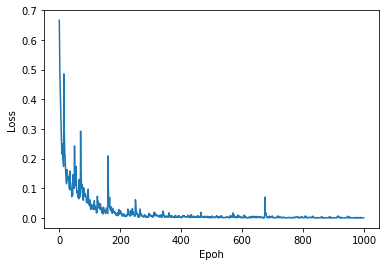

In [126]:
plt.plot(lossPoints)
plt.xlabel('Epoh')
plt.ylabel('Loss')

In [130]:
tocno = 0
total = 0
with torch.no_grad():
	for data in train_dataloader:
		inputs, labels = data
		inputs = inputs.to(device)
		labels = labels.to(device)

		outs = eegnet(inputs)
		# torch.max(tensor, 1) vraca poziciju neurona na kojemu je max vrijednost
		_, predicted = torch.max(outs.data, 1)
		total += labels.size(0)
		tocno += (predicted == labels).sum().item()
		print ("klasificiram uzorak: " + str(total), end="\r")

print('Model je točno klasificirao epohe %d%% puta NA PODATCIMA TRENIRANJA' % (100*tocno/total))

Model je točno klasificirao epohe 100% puta NA PODATCIMA TRENIRANJA


In [131]:
# Definiranje dataloadera za testne podatke
eeg_2s_raw = scio.loadmat('./data/subject_1_eeg_separated_epochs_2s.mat')

downsapling = 2
# Prvo se podatci downsampleaju downsapling puta
# zatim se filtriraju PP Butt filtrom 4. reda od 0.1hz do 20hz
# zatim se podatci normaliziraju po (pdf: CNN for P300 Detec... sekcija 3.1 na stranici 436)
test_data = eegDataset(eeg_2s_raw, 1/3, 'abc', transform=transforms.Compose([
    DownSample(downsapling),
    BPButter4(0.1, 20, 1024/downsapling),
    Normalise()
]), filterChain=[
    F_RemoveOutliers(200)
])


test_dataloader = DataLoader(test_data, batch_size=4, shuffle=True)

In [132]:
tocno2 = 0
total2 = 0
with torch.no_grad():
	for data in test_dataloader:
		inputs, labels = data
		inputs = inputs.to(device)
		labels = labels.to(device)
		
		outs = eegnet(inputs)
		# torch.max(tensor, 1) vraca poziciju neurona na kojemu je max vrijednost
		_, predicted = torch.max(outs.data, 1)
		total2 += labels.size(0)
		tocno2 += (predicted == labels).sum().item()
		print ("klasificiram uzorak: " + str(total2), end="\r")

print('Model je točno klasificirao epohe %d%% puta NA NOVIM PODATCIMA' % (100*tocno2/total2))

Model je točno klasificirao epohe 83% puta NA NOVIM PODATCIMA
